In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append("../")

In [11]:
from pathlib import Path
data_root = Path("../../data/AAPI")

## Crop sections with shape of 3000*3000 from slides

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from ml_core.utils.slide_utils import crop_ROI_using_annotations
from ml_core.utils.annotations import load_annotations_from_asap_xml

In [5]:
def crop_ROI_from_slide(slide_path, annotation_path, save_dir):
    annotations = load_annotations_from_asap_xml(annotation_path)
    group_names = set([a.group_name for a in annotations])
    class_names = group_names.intersection({"Glomerulus", "Arteriole", "Tubules", "Artery"})
    print(f"{class_names} were used.\nOld classes: {group_names}.")
    for class_name in class_names:
        print(f"Start cropping ROIs for {class_name} ...")
        crop_ROI_using_annotations(slide_path, 
                                   save_dir, 
                                   annotations, 
                                   class_name, 
                                   SECTION_SIZE)
        print(f"Finish cropping ROIs for {class_name}")

In [6]:
with open("../../data/AAPI_dataset/slides/train_val_test_split.json") as f:
    test_val_dict = json.loads(f.read())

test_slide_paths = [data_root / Path(f"slides/{n}") for n in test_val_dict["test"]]
val_slide_paths = [data_root / Path(f"slides/{n}") for n in test_val_dict["val"]]
train_slide_paths = [p for p in (data_root / Path(f"slides/")).glob("*.svs") if p not in test_slide_paths+val_slide_paths]

In [7]:
assert np.all([p.exists() for p in test_slide_paths + val_slide_paths + train_slide_paths])
assert train_slide_paths

In [8]:
SECTION_SIZE=3000

for split_name, paths in zip(("train", "test", "val"), (train_slide_paths, test_slide_paths, val_slide_paths)):
    save_dir = data_root / Path(f"ROI_data/{split_name}")
    print("*"*10 + f" {split_name.upper()} " + "*"*10)
    for slide_path in paths:
        annotation_path = slide_path.with_suffix(".xml")
        print("="*10 + f" Slide {slide_path.name} " + "="*10)
        crop_ROI_from_slide(slide_path, annotation_path, save_dir)
        print()

********** TRAIN **********
========== Slide slide_008.svs ==========
{'Arteriole', 'Tubules', 'Artery', 'Glomerulus'} were used.
Old classes: {'Arteriole', 'Artery', 'Biopsy', 'Tubules', 'Glomerulus', 'Glomerulus_GS'}.
Start cropping ROIs for Arteriole ...
Finish cropping ROIs for Arteriole
Start cropping ROIs for Tubules ...
Finish cropping ROIs for Tubules
Start cropping ROIs for Artery ...
Finish cropping ROIs for Artery
Start cropping ROIs for Glomerulus ...
Finish cropping ROIs for Glomerulus

========== Slide slide_001.svs ==========
{'Arteriole', 'Tubules', 'Artery', 'Glomerulus'} were used.
Old classes: {'Arteriole', 'Interstitium', 'Artery', 'Tubules', 'Glomerulus', 'Glomerulus_GS', 'Biopsy_core'}.
Start cropping ROIs for Arteriole ...
Finish cropping ROIs for Arteriole
Start cropping ROIs for Tubules ...
Finish cropping ROIs for Tubules
Start cropping ROIs for Artery ...
Finish cropping ROIs for Artery
Start cropping ROIs for Glomerulus ...
Finish cropping ROIs for Glomerulu

## Export to HDF5

In [9]:
from ml_core.preprocessing.patches_extraction import Extractor, crop_and_save_patches_to_hdf5

In [12]:
output_root = data_root / "./hdf5_data"
output_root.mkdir(exist_ok=True)

In [16]:
for class_name in ["Tubules"]:
    extractor = Extractor(config_section_name=f"AAPI_{class_name}")
    
    for split in ("test",):
        fpaths = (data_root / f"ROI_data/{split}/{class_name}").glob("*.png")
        fpaths = list(filter(lambda path: "mask" not in path.name, fpaths))
        roi_mask_mappings = {"roi": [], "mask": []}
        
        for fpath in fpaths:
            mask_path = Path(str(fpath).replace(".png", "_mask.png"))
            if mask_path.exists():
                roi_mask_mappings["roi"].append(fpath)
                roi_mask_mappings["mask"].append(mask_path)
                    
        assert roi_mask_mappings
        assert len(roi_mask_mappings["roi"]) == len(fpaths)
        
        hdf5_name = f"patch_{extractor.patch_size}/{class_name}_{split}.h5"
        output_path = output_root / hdf5_name
        if not output_path.parent.exists():
            output_path.parent.mkdir(parents=True, exist_ok=True)
        
        crop_and_save_patches_to_hdf5(output_root / hdf5_name,
                                      images=roi_mask_mappings["roi"],
                                      masks=roi_mask_mappings["mask"],
                                      extractor=extractor)
        
        print(f"Finish saving {hdf5_name}.")

/home/henryhuang/.conda/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


Finish saving patch_256/Tubules_test.h5.


In [19]:
from ml_core.preprocessing.dataset import create_dataloader, visualize_one_sample

In [18]:
dl, dataset = create_dataloader(output_root / "patch_256/Tubules_test.h5", return_dataset=True)

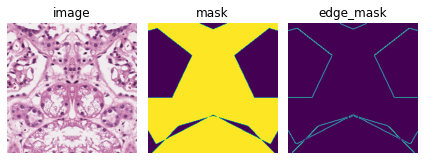

In [32]:
visualize_one_sample(dataset, 230)